<a href="https://colab.research.google.com/github/hansong0219/Advanced-Deep-learning-Notebooks/blob/master/Cross-Domain/CycleGAN_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ResNet 생성자를 이용한 Cycle GAN 모델 

ResNet 구조는 이전 층의 전보를 네트워 앞쪽에 한개 이상의 층으로 스킵한다는 부분에서 U-Net 과 비슷하나, U-Net 은 다운샘플링 층을 이에 상응하는 업샘플링 층으로 연결하여 U 모양을 구성하는 대신 ResNet은 Residual block 을 차례대로 쌓아 구성하게된다. 

각 블록은 다음의 층으로 출력을 전달하기 전에 입력과 출력을 합하는 스킵 연결층을 가지고 있다.

ResNet  구조는 수백 또는 수천개의 층도 훈련할 수 있는데 앞쪽에 층에 도달하는 그레디언트가 매우 작아져 매우 느리게 훈련되는 vanishing gradient 문제가 없고,Error gradient 가 Residual Block 의 스킵 연결을 통해 네트워크에 그대로 역전파 되기 때문이다. 또, 층을 추가해도 모델의 정확도를 떨어뜨리지 않는데 추가적인 특성이 추출되지 않는다면, 스킵연결로 인해 언제든지 이전 층의 특성이 identify mapping 을 통과하기 때문이다.

본 Notebook 에서는 Residual block 을 사용한 생성자를 구성하여 Image Style Transfer 를 수행할 예정이다.

In [ ]:
import numpy as np
import os
import sys
from tensorflow.keras.layers import Input, Dropout, concatenate, add, Layer
from tensorflow.keras.layers import Conv2DTranspose, Conv2D 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LeakyReLU, Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow_addons.layers import InstanceNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import BinaryCrossentropy
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

import cv2
import math
import datetime
import imageio

# GPU 할당

In [ ]:
import tensorflow as tf 
physical_devices =tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0],True)

# 유틸 함수 정의


### 이미지 및 데이터 재구성 유틸

In [ ]:
def display_images(imgs, filename, title='', imgs_dir=None, show=False):
  
    #이미지를 nxn 으로 나타냄
    rows = imgs.shape[1]
    cols = imgs.shape[2]
    channels = imgs.shape[3]
    side = int(math.sqrt(imgs.shape[0]))
    assert int(side * side) == imgs.shape[0]

    # 이미지 저장을 위한 폴더를 만듦
    if imgs_dir is None:
        imgs_dir = 'saved_images'
    save_dir = os.path.join(os.getcwd(), imgs_dir)
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    filename = os.path.join(imgs_dir, filename)
    # 이미지의 shape 을 지정
    if channels==1:
        imgs = imgs.reshape((side, side, rows, cols))
    else:
        imgs = imgs.reshape((side, side, rows, cols, channels))
    imgs = np.vstack([np.hstack(i) for i in imgs])
    plt.figure()
    plt.axis('off')
    plt.title(title)
    if channels==1:
        plt.imshow(imgs, interpolation='none', cmap='gray')
    else:
        plt.imshow(imgs, interpolation='none')
    plt.savefig(filename)
    if show:
        plt.show()
    
    plt.close('all')


def test_generator(generators, test_data, step, titles, dirs, todisplay=100, show=False):
    # generator 모델을 테스트함
    # 입력 인수
    """
    generators (tuple): 소스와 타겟 생성기
    test_data (tuple): 소스와 타겟 데이터
    step (int): 진행 단계
    titles (tuple): 표시 이미지의 타이틀
    dirs (tuple): 이미지 저장 폴더
    todisplay (int): 저장이미지의 수 (정사각형 형태로 생성되어야 한다.)
    show (bool): 이미지 표시 여부
    """

    # test data 로 부터 output 예측
    g_source, g_target = generators
    test_source_data, test_target_data = test_data
    t1, t2, t3, t4 = titles
    title_pred_source = t1
    title_pred_target = t2
    title_reco_source = t3
    title_reco_target = t4
    dir_pred_source, dir_pred_target = dirs

    pred_target_data = g_target.predict(test_source_data)
    pred_source_data = g_source.predict(test_target_data)
    reco_source_data = g_source.predict(pred_target_data)
    reco_target_data = g_target.predict(pred_source_data)

    # 정사각형 형태의 하나의 이미지로 나타냄
    imgs = pred_target_data[:todisplay]
    filename = '%06d.png' % step
    step = " Step: {:,}".format(step)
    title = title_pred_target + step
    display_images(imgs,
                   filename=filename,
                   imgs_dir=dir_pred_target,
                   title=title,
                   show=show)

    imgs = pred_source_data[:todisplay]
    title = title_pred_source
    display_images(imgs,
                   filename=filename,
                   imgs_dir=dir_pred_source,
                   title=title,
                   show=show)

    imgs = reco_source_data[:todisplay]
    title = title_reco_source
    filename = "reconstructed_source.png"
    display_images(imgs,
                   filename=filename,
                   imgs_dir=dir_pred_source,
                   title=title,
                   show=show)

    imgs = reco_target_data[:todisplay]
    title = title_reco_target
    filename = "reconstructed_target.png"
    display_images(imgs,
                   filename=filename,
                   imgs_dir=dir_pred_target,
                   title=title,
                   show=show)


def process_data(data, titles, filenames, todisplay=100):
    source_data, target_data, test_source_data, test_target_data = data
    test_source_filename, test_target_filename = filenames
    test_source_title, test_target_title = titles

    # 테스트 타겟 이미지 표시
    imgs = test_target_data[:todisplay]
    display_images(imgs,
                   filename=test_target_filename,
                   title=test_target_title)

    # 테스트 소스이미지 표시
    imgs = test_source_data[:todisplay]
    display_images(imgs,
                   filename=test_source_filename,
                   title=test_source_title)

    # 이미지 표시 정리
    target_data = target_data.astype('float32')  / 127.5 - 1
    test_target_data = test_target_data.astype('float32') / 127.5 - 1

    source_data = source_data.astype('float32')  / 127.5 - 1
    test_source_data = test_source_data.astype('float32') / 127.5 - 1

    # 소스, 타겟, 테스트 데이터
    data = (source_data, target_data, test_source_data, test_target_data)

    rows = source_data.shape[1]
    cols = source_data.shape[2]
    channels = source_data.shape[3]
    source_shape = (rows, cols, channels)

    rows = target_data.shape[1]
    cols = target_data.shape[2]
    channels = target_data.shape[3]
    target_shape = (rows, cols, channels)

    shapes = (source_shape, target_shape)
    
    return data, shapes

### 데이터 불러오기 유틸

In [ ]:
def imread(path):
    return imageio.imread(path,as_gray=False,pilmode='RGB').astype(np.float)

def load_data(dataset_path, is_test=False):
  data_type = "train" if not is_test else "val"
  path_source = glob(dataset_path + '/%sA/*' %(data_type))
  path_target = glob(dataset_path + '/%sB/*' %(data_type))
    
  source_data, target_data = [], []
  for source, target in zip(path_source, path_target):
    img_source = imread(source)
    img_target = imread(target)

    img_source = np.array(img_source)
    img_target = np.array(img_target)

    if is_test and np.random.random()>0.5:
      img_source = np.fliplr(img_source)
      img_target = np.fliplr(img_target)
    
    source_data.append(img_source)
    target_data.append(img_target)
    
  return np.array(source_data), np.array(target_data)

In [ ]:
# 데이터 불러오기 및 확인
dataset_path = "D:/data/vangogh2photo"
source_data, target_data = load_data(dataset_path)

plt.figure()
plt.imshow(source_data[0]/255.0)
plt.figure()
plt.imshow(target_data[0]/255.0)

# 모델 구성

### ReflectionPadding2D

CycleGAN 논문 및 Source 를 통해 ResNet 생성기의 Layer 구조에서 Reflection Padding을 사용하는 것이 ZerosPadding을 사용하는 Conv2D의 padding=same 조건에 비해 권장 되었다. 따라서 ResNet 생성기에는 ReflectionPadding2D의 Class를 지정하여 사용한다.

In [ ]:
class ReflectionPadding2D(Layer):
    # ReflectionPadding Layer 를 실행할 수 있도록 구성된 class
    
    # 입력인수
    """
    padding(tuple): padding을 위한 특정 차원의 크기로 지정된다. 
    """
    # 출력 : padding 이 실행된 텐서를 출력한다.

    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def call(self, input_tensor, mask=None):
        padding_width, padding_height = self.padding
        padding_tensor = [
            [0, 0],
            [padding_height, padding_height],
            [padding_width, padding_width],
            [0, 0],
        ]
        return tf.pad(input_tensor, padding_tensor, mode="REFLECT")

# 모델 Build 함수 정의

### 모델 구성층 구성 함수
ResNet 을 생성자로 하는 Cycle GAN 의 구성요소는 크게 3가지로 분류할 수 있다. 

1. 생성자와 판별자의 encoder(downsampling) layer
2. 생성자의 Residual Block Unit
3. 생성자의 decoder(upsampling) layer

In [ ]:
def encoder_layer(inputs, filters=16, kernel_size=3, strides = 2,  activation='relu', instance_norm=True):
  #Conv2D -IN - ReLU(LeakyReLU) 의 인코더 층을 구성한다.
  kernel_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

  x = inputs
  x = Conv2D(filters, kernel_size=kernel_size, strides=strides,kernel_initializer=kernel_init, padding = 'same')(x)
  if instance_norm:
    x = InstanceNormalization()(x)

  if activation=='relu':
    x = Activation(activation)(x)
  else:
    x = LeakyReLU(alpha=0.2)(x)

  return x

def decoder_layer(inputs, filters=16, kernel_size=3, strides=2, activation='relu', instance_norm = True):
  #Conv2DTranspose-IN-LeakyReLU로 구성된 디코더 계층구성, 활성화 함수는 ReLU 로 교체될 수 있음
  kernel_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

  x = inputs
  x = Conv2DTranspose(filters, kernel_size=kernel_size, strides=strides, kernel_initializer = kernel_init, padding='same')(x)
  if instance_norm:
    x = InstanceNormalization()(x)
  
  if activation=='relu':
    x = Activation(activation)(x)
  else:
    x = LeakyReLU(alpha=0.2)(x)

  return x

def residual_block(inputs, filters=64, kernel_size=3, resblock=2):
  # shorcut 연결 구현한 Residual Block
  kernel_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
  shortcut = inputs

  for num_unit in range(resblock):
    if num_unit == 0:
      x = ReflectionPadding2D(padding=(1,1))(inputs)
    else:
      x = ReflectionPadding2D(padding=(1,1))(x)
    
    x = Conv2D(filters, kernel_size=kernel_size, strides=1, padding='valid', kernel_initializer=kernel_init)(x)
    x = InstanceNormalization()(x)

    if num_unit != resblock-1:
      x = Activation('relu')(x)
 
  return add([shortcut, x])

### 생성기 Build 함수 구현

In [ ]:
# 생성기 Build 함수
def build_generator_resnet(input_shape, output_shape=None, filters=64, num_encoders=2, num_residual_blocks=9, num_decoders =2, name=None):
  inputs = Input(shape=input_shape)
  channels = int(output_shape[-1])
  kernel_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

  x = ReflectionPadding2D(padding=(3, 3))(inputs)
  x = Conv2D(filters, kernel_size=7, strides=1, padding='valid', kernel_initializer = kernel_init, use_bias=False)(x)
  x = InstanceNormalization()(x)
  x = Activation('relu')(x)

  #DownSampling
  for _ in range(num_encoders):
    filters *=2
    x = encoder_layer(x, filters=filters)
  
  #Residual Block 층 구성
  for _ in range(num_residual_blocks):
    x = residual_block(x, filters=filters)

  #UpSampling
  for _ in range(num_decoders):
    filters//=2
    x = decoder_layer(x, filters=filters)

  #Final Block
  x = ReflectionPadding2D(padding=(3, 3))(x)
  x = Conv2D(3, (7, 7), padding="valid")(x)
  x = Activation("tanh")(x)

  return Model(inputs, x, name=name)

### 판별자 Build 함수 (Patch GAN)

In [ ]:
def build_discriminator(input_shape, filters=64, kernel_size=4, num_encoder=3, name=None):
  kernel_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
  
  inputs = Input(shape=input_shape)
  x = encoder_layer(inputs, filters = filters, kernel_size = kernel_size, strides=2, activation='leaky_relu', instance_norm=False) 

  num_filters=filters
  for num_block in range(num_encoder):
    num_filters *= 2
    if num_block < num_encoder-1:
      x = encoder_layer(x, filters=num_filters, kernel_size = kernel_size, strides = 2, activation='leaky_relu') 
    else:
      x = encoder_layer(x, filters=num_filters, kernel_size = kernel_size, strides = 1, activation='leaky_relu')

  outputs = Conv2D(1, (4,4), strides=1, padding='same', kernel_initializer = kernel_init)(x)

  return Model(inputs, outputs, name=name)

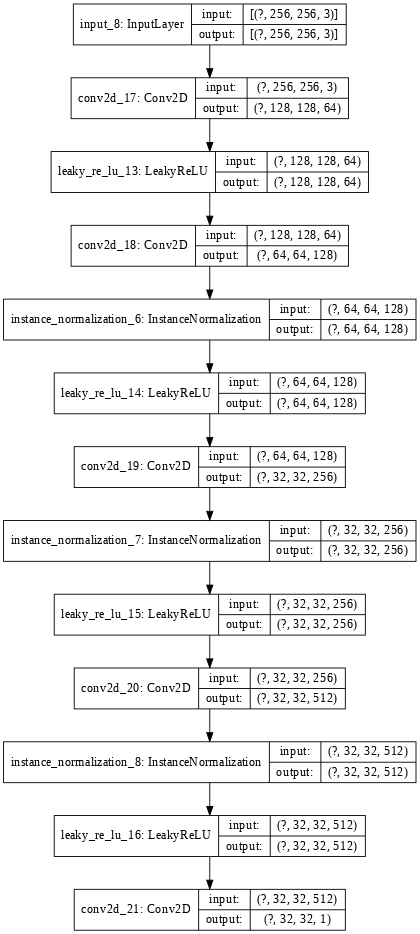

In [ ]:
#model_fine tuning 변수


